In [1]:
import matplotlib
matplotlib.use('Agg')
from pyalgotrade.bitstamp import barfeed
from pyalgotrade.bitstamp import broker
from pyalgotrade import strategy
from pyalgotrade.technical import ma
from pyalgotrade.technical import cross

SyntaxError: invalid syntax (livefeed.py, line 137)

In [2]:
class Strategy(strategy.BaseStrategy):
    def __init__(self, feed, brk):
        strategy.BaseStrategy.__init__(self, feed, brk)
        smaPeriod = 20
        self.__instrument = "BTC"
        self.__prices = feed[self.__instrument].getCloseDataSeries()
        self.__sma = ma.SMA(self.__prices, smaPeriod)
        self.__bid = None
        self.__ask = None
        self.__position = None
        self.__posSize = 0.05

        # Subscribe to order book update events to get bid/ask prices to trade.
        feed.getOrderBookUpdateEvent().subscribe(self.__onOrderBookUpdate)

    def __onOrderBookUpdate(self, orderBookUpdate):
        bid = orderBookUpdate.getBidPrices()[0]
        ask = orderBookUpdate.getAskPrices()[0]

        if bid != self.__bid or ask != self.__ask:
            self.__bid = bid
            self.__ask = ask
            self.info("Order book updated. Best bid: %s. Best ask: %s" % (self.__bid, self.__ask))

    def onEnterOk(self, position):
        self.info("Position opened at %s" % (position.getEntryOrder().getExecutionInfo().getPrice()))

    def onEnterCanceled(self, position):
        self.info("Position entry canceled")
        self.__position = None

    def onExitOk(self, position):
        self.__position = None
        self.info("Position closed at %s" % (position.getExitOrder().getExecutionInfo().getPrice()))

    def onExitCanceled(self, position):
        # If the exit was canceled, re-submit it.
        self.__position.exitLimit(self.__bid)

    def onBars(self, bars):
        bar = bars[self.__instrument]
        self.info("Price: %s. Volume: %s." % (bar.getClose(), bar.getVolume()))

        # Wait until we get the current bid/ask prices.
        if self.__ask is None:
            return

        # If a position was not opened, check if we should enter a long position.
        if self.__position is None:
            if cross.cross_above(self.__prices, self.__sma) > 0:
                self.info("Entry signal. Buy at %s" % (self.__ask))
                self.__position = self.enterLongLimit(self.__instrument, self.__ask, self.__posSize, True)
        # Check if we have to close the position.
        elif not self.__position.exitActive() and cross.cross_below(self.__prices, self.__sma) > 0:
            self.info("Exit signal. Sell at %s" % (self.__bid))
            self.__position.exitLimit(self.__bid)


NameError: name 'strategy' is not defined

In [3]:
barFeed = barfeed.LiveTradeFeed()
brk = broker.PaperTradingBroker(1000, barFeed)
strat = Strategy(barFeed, brk)

strat.run()

NameError: name 'barfeed' is not defined

Charting
---------

In [6]:
from pyalgotrade.bitcoincharts import barfeed
from pyalgotrade.tools import resample
from pyalgotrade import bar
import pandas as pd
import datetime
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Downloading the ANX exchange series

In [3]:
fromtimestamp = lambda x:datetime.datetime.fromtimestamp(int(x))
# df = pd.read_csv('http://api.bitcoincharts.com/v1/csv/anxhkUSD.csv.gz', sep=',', header=None)

df = pd.read_csv('anxhkUSD.csv.gz', sep=',', header=None, converters={0: fromtimestamp}, index_col=0)

In [4]:
df.to_csv('anxhkUSD.csv')

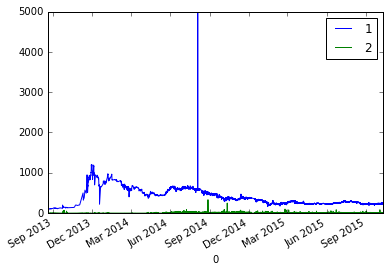

In [7]:
df.plot();

In [32]:
barFeed = barfeed.CSVTradeFeed()
barFeed.addBarsFromCSV("anxhkUSD.csv", fromDateTime=datetime.datetime(2014, 1, 1))
resample.resample_to_csv(barFeed, bar.Frequency.MINUTE*30, "30min-anxhkUSD.csv")

TypeError: iter() returned non-iterator of type 'FastDictReader'

In [34]:
from pyalgotrade import bar
from pyalgotrade import strategy
from pyalgotrade import plotter
from pyalgotrade.technical import vwap
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.bitstamp import broker
from pyalgotrade import broker as basebroker


class VWAPMomentum(strategy.BacktestingStrategy):
    MIN_TRADE = 5

    def __init__(self, feed, brk, instrument, vwapWindowSize, buyThreshold, sellThreshold):
        strategy.BacktestingStrategy.__init__(self, feed, brk)
        self.__instrument = instrument
        self.__vwap = vwap.VWAP(feed[instrument], vwapWindowSize)
        self.__buyThreshold = buyThreshold
        self.__sellThreshold = sellThreshold

    def _getActiveOrders(self):
        orders = self.getBroker().getActiveOrders()
        buy = filter(lambda o: o.isBuy(), orders)
        sell = filter(lambda o: o.isSell(), orders)
        return buy, sell

    def _cancelOrders(self, orders):
        brk = self.getBroker()
        for o in orders:
            self.info("Canceling order %s" % (o.getId()))
            brk.cancelOrder(o)

    def _buySignal(self, price):
        buyOrders, sellOrders = self._getActiveOrders()
        self._cancelOrders(sellOrders)

        brk = self.getBroker()
        cashAvail = brk.getCash() * 0.98
        size = round(cashAvail / price, 3)
        if len(buyOrders) == 0 and price*size > VWAPMomentum.MIN_TRADE:
            self.info("Buy %s at %s" % (size, price))
            try:
                self.limitOrder(self.__instrument, price, size)
            except Exception as e:
                self.error("Failed to buy: %s" % (e))

    def _sellSignal(self, price):
        buyOrders, sellOrders = self._getActiveOrders()
        self._cancelOrders(buyOrders)

        brk = self.getBroker()
        shares = brk.getShares(self.__instrument)
        if len(sellOrders) == 0 and shares > 0:
            self.info("Sell %s at %s" % (shares, price))
            self.limitOrder(self.__instrument, price, shares*-1)

    def getVWAP(self):
        return self.__vwap

    def onBars(self, bars):
        vwap = self.__vwap[-1]
        if vwap is None:
            return

        price = bars[self.__instrument].getClose()
        if price > vwap * (1 + self.__buyThreshold):
            self._buySignal(price)
        elif price < vwap * (1 - self.__sellThreshold):
            self._sellSignal(price)

    def onOrderUpdated(self, order):
        if order.isBuy():
            orderType = "Buy"
        else:
            orderType = "Sell"
        self.info("%s order %d updated - Status: %s - %s" % (
            orderType,
            order.getId(),
            basebroker.Order.State.toString(order.getState()),
            order.getExecutionInfo(),
        ))

ImportError: No module named 'slippage'

In [ ]:
def main(plot):
    instrument = "BTC"
    initialCash = 1000
    vwapWindowSize = 100
    buyThreshold = 0.02
    sellThreshold = 0.01

    barFeed = csvfeed.GenericBarFeed(bar.Frequency.MINUTE*30)
    barFeed.addBarsFromCSV(instrument, "30min-bitstampUSD.csv")
    brk = broker.BacktestingBroker(initialCash, barFeed)
    strat = VWAPMomentum(barFeed, brk, instrument, vwapWindowSize, buyThreshold, sellThreshold)

    if plot:
        plt = plotter.StrategyPlotter(strat)
        plt.getInstrumentSubplot(instrument).addDataSeries("VWAP", strat.getVWAP())

    strat.run()

    if plot:
        plt.plot()
        
main(True)